In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm

### Mixed-membership

We want to sample nodes that come from a mixed membership model, i.e. less good clustering. Then want to test how good our bootstraps of nodes look, and apply our KL test to test this formally.

In [8]:
# Code up a mixed membership model 
K=3
n= 300

# use our new function to make a MMSBM
A, largest_prob, P = make_MMSBM(n, K)

A = A.astype(float)
ya = UASE([A], 2)
plot_embedding(ya, n, 1, largest_prob)

This isn't actually community, it is just the one probabilistically they are most likely to belong to

In [9]:
@nb.njit
def P_est_from_A_obs(n, A_obs, n_neighbors, indices):
    P_est = np.zeros((n, n))
    for i in range(n):
        idx = indices[i]
        A_i = (1/n_neighbors) * np.sum(A_obs[:, idx], axis=1)
        P_est[:, i] = A_i
    return P_est

In [55]:





def test_bootstrap(A, d, dc=False):
    n = A.shape[0]
    A_obs = A.copy()

    # Embed the graphs -------------------------------  

    if dc:
        yhat = UASE([A], d=d+1, flat=True)
        tol=1e-12
        norms = np.linalg.norm(yhat, axis=1)
        idx = np.where(norms > tol)
        yhat_dc = yhat.copy()
        yhat_dc[idx] = yhat_dc[idx] / norms[idx][:, None]
        yhat = yhat_dc
            
    else:
        yhat = UASE([A], d=d, flat=True)

    # run a k-NN on the embedding yhat
    n_neighbors = 5

    # Here we use Minkowski distance
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(yhat)
    distances, indices = nbrs.kneighbors(yhat)

    # Estimate the P matrix -------------------------------
    P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)

    # Bootstrap -----------------------------------------
    B = 100
    p_vals = []
    A_boots = []
    for i in range(B):
        A_est = make_inhomogeneous_rg(P_est)

        if dc:
            # Undo degree correction
            A_est = A_est * np.outer(norms, norms)

        yhat_est = UASE([A_obs,A_est], d=K)
        p_val = test_temporal_displacement_two_times(yhat_est, n)
        p_vals.append(p_val)
        A_boots.append(A_est)

    return p_vals, A_boots


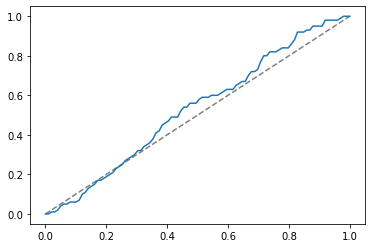

0.04

In [17]:
A_obs = A.copy()
p_vals, A_ests = test_bootstrap(A_obs, K)
A_est = A_ests[0]

plot_power(p_vals, plot=True)

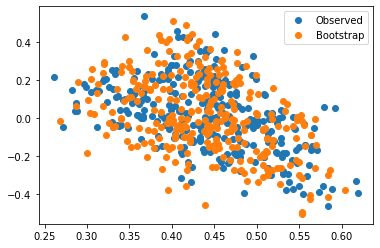

In [18]:
A_res = make_inhomogeneous_rg(P)

yhat_est = UASE([A_obs,A_est, A_res], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)
# plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)

plt.legend()

### Degree-heterogeneous & sparse

In [39]:
n = 1000
As, Ps = make_iid_close_power(n, T=1)
# ya = UASE(As, 2)
# plot_embedding(ya, n, 1, tau)

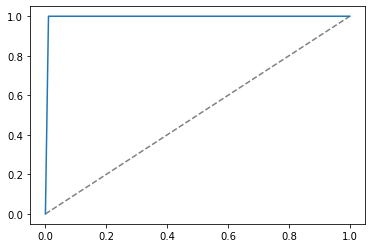

1.0

In [56]:
A_obs = As[0]
p_vals, A_ests = test_bootstrap(A_obs, d=2, dc=True)
A_est = A_ests[0]
plot_power(p_vals, plot=True)

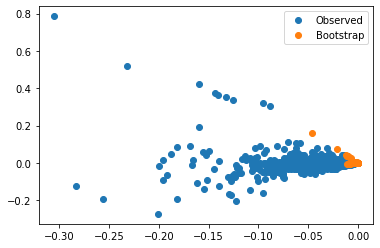

In [58]:
A_res = make_inhomogeneous_rg(Ps[0])
yhat_est = UASE([A_obs,A_est, A_res], d=2, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)
# plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)

plt.legend()